# Term Deposit Marketing

## Background
### We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

### We are interested in developing a robust machine learning system that leverages information coming from call center data.

### Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

### Data Description:

### The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

## Attributes

### age : age of customer (numeric)

### job : type of job (categorical)

### marital : marital status (categorical)

### education (categorical)

### default: has credit in default? (binary)

### balance: average yearly balance, in euros (numeric)

### housing: has a housing loan? (binary)

### loan: has personal loan? (binary)

### contact: contact communication type (categorical)

### day: last contact day of the month (numeric)

### month: last contact month of year (categorical)

### duration: last contact duration, in seconds (numeric)

### campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Output (desired target):

### y - has the client subscribed to a term deposit? (binary)

## The goal of this project is to predict if the customer will subscribe (yes/no) to a term deposit (variable y).


In [551]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import sqrt
from numpy import argmax

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [552]:
#loading the data
tdm=pd.read_csv('term-deposit-marketing-2020.csv')
tdm.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [553]:
tdm.shape 

(40000, 14)

### We have 40,000 rows and 14 columns.

In [554]:
tdm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


### We have a mix of quantitative and categorical data. There are no null values in the data set.

In [555]:
tdm.isnull().sum() #No null/missing variables

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [556]:
#Counting the number of 'unknown' string in the categorical columns
tdm['job'].str.contains('unk').sum()
tdm['education'].str.contains('unk').sum()
tdm['contact'].str.contains('unk').sum()

12765

<Axes: title={'center': 'Proportion of Clients who have subscribed to a Term Deposit'}, ylabel='count'>

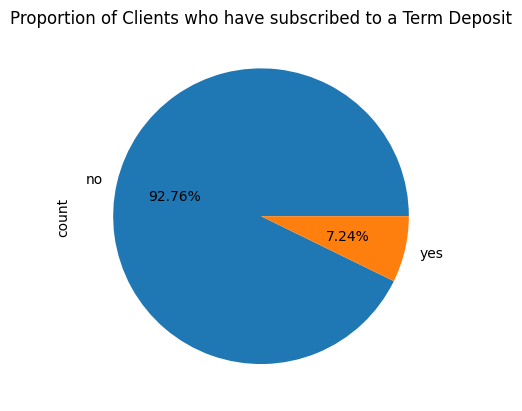

In [557]:
#Data Exploration
#Visualisation of target column relative frequency
tdm['y'].value_counts().plot(kind='pie',autopct='%1.2f%%',
                             title='Proportion of Clients who have subscribed to a Term Deposit')


### The data is highly unbalanced.

In [558]:
#Correlation between numerical variables
#First convert target variable to 0 and 1
tdm['y']=tdm['y'].map({'yes': 1, 'no': 0})
tdm.corr(numeric_only=True)


,age,balance,day,duration,campaign,y
age,1.000000,0.081517,-0.011689,-0.036270,0.016204,-0.020273
balance,0.081517,1.000000,0.011662,0.014072,-0.008137,0.030232
day,-0.011689,0.011662,1.000000,-0.032983,0.165429,-0.006420
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387,0.461169
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000,-0.040350
y,-0.020273,0.030232,-0.006420,0.461169,-0.040350,1.000000


### There is no multicollinearity amongst the numerical variables and target.


## Data Exploration

### We will now look at the different variables, starting with the age variable.

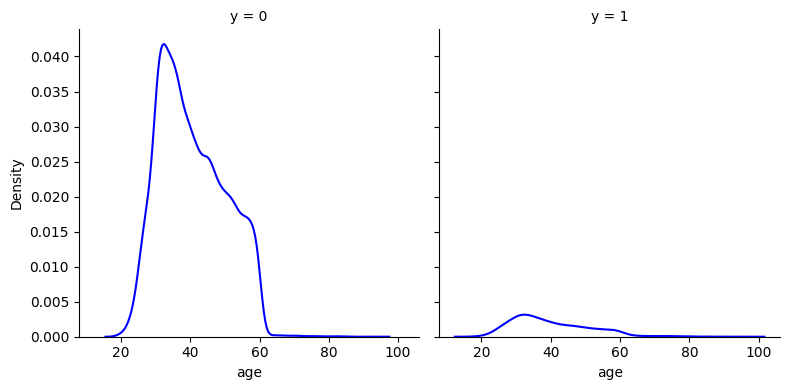

In [559]:
#Age variable
g = sns.displot( kind='kde', data=tdm, x='age',
                 col='y', col_wrap=2,
                 height=4, aspect=1, color='blue')

plt.show()


### The majority of the respondents are between the ages of 25 and 60.

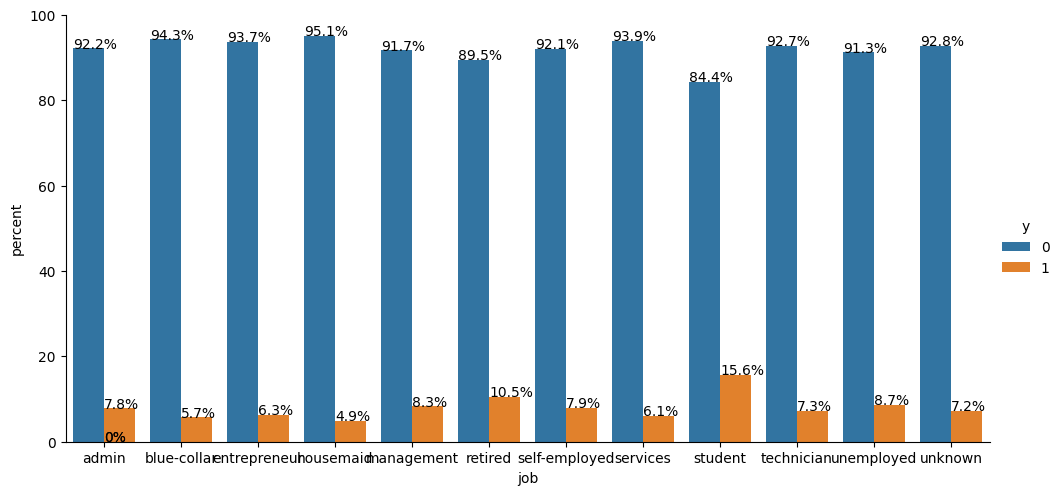

In [560]:
#First job
df1 = tdm.groupby('job')['y'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x='job',y='percent',hue='y',kind='bar',data=df1, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [561]:
#Testing for statistical significance of proportion of 1 student vs 1 housemaid
yes_student = tdm.loc[tdm['job'] == 'student', 'y']
yes_housemaid = tdm.loc[tdm['job'] == 'housemaid', 'y']
from statsmodels.stats.weightstats import ttest_ind

# Conducting two-sample ttest
result_ttest = ttest_ind(yes_student, yes_housemaid)
 
# Print the result
print(result_ttest)

(7.4304178356386394, 1.7491301430998064e-13, 1609.0)


### Since the p-value is extremely small, we can reject the null hypothesis (u1=u2). This implies that the mean proportion of term deposit for the two data groups (student & housemaid) is statistically different.

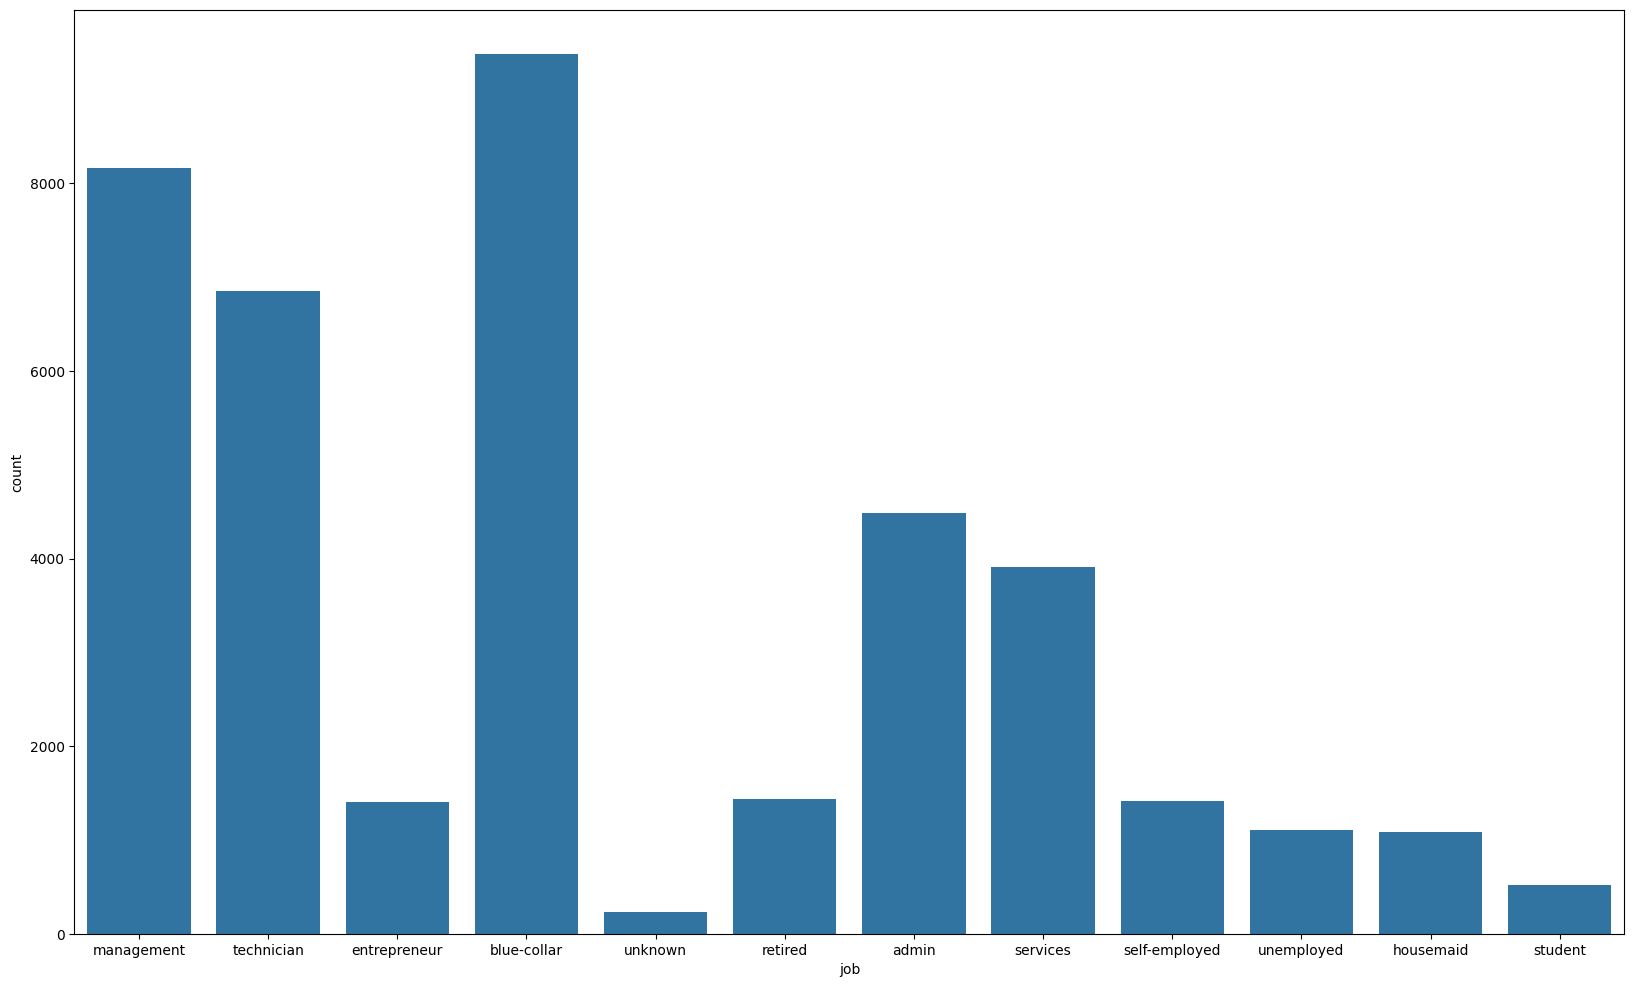

In [562]:
plt.figure(figsize=(20, 12))
sns.countplot(data=tdm, x='job')
plt.show()

### The majority of respondents have blue-collar and management jobs. Amongts all types of jobs, the percentage of respondents who subscribed to a term deposit varies between 4.9% to 15.6%, the latter being students.

In [563]:
#Marital Status
tdm['marital'].value_counts() #The majority of respondents are married.

marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64

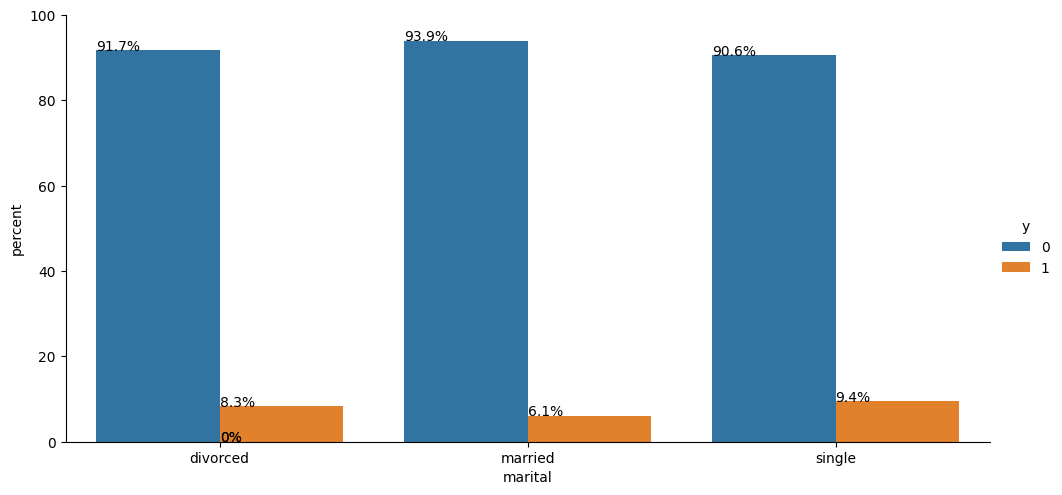

In [564]:
#Marital
df2 = tdm.groupby('marital')['y'].value_counts(normalize=True)
df2 = df2.mul(100)
df2 = df2.rename('percent').reset_index()

g = sns.catplot(x='marital',y='percent',hue='y',kind='bar',data=df2, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### 61% of respondents are married, 27% are single and the rest is divorced. The proportion of respondents who subscribed to a term deposit is pretty uniform among marital statuses from 6.1%, for married folks, to 8.3% for divorcees and 9.4% for singles.

<Axes: xlabel='education', ylabel='count'>

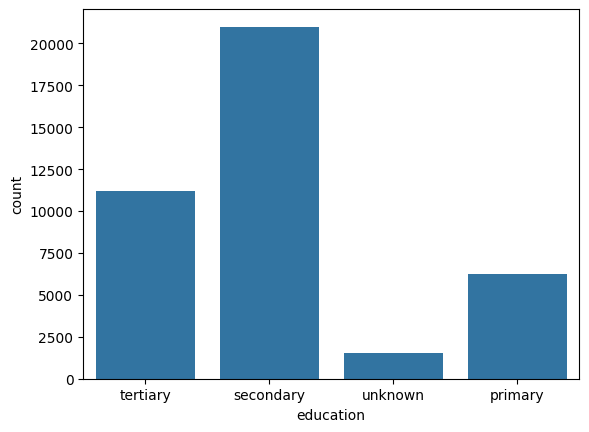

In [565]:
#Education
sns.countplot(data=tdm, x='education') 

### Almost half of the respondents reached the secondary level of eduction.The proportion of 'yes' responses is greater among respondents with tertiary level of education (9.2% compared to around 6% for other education levels.)

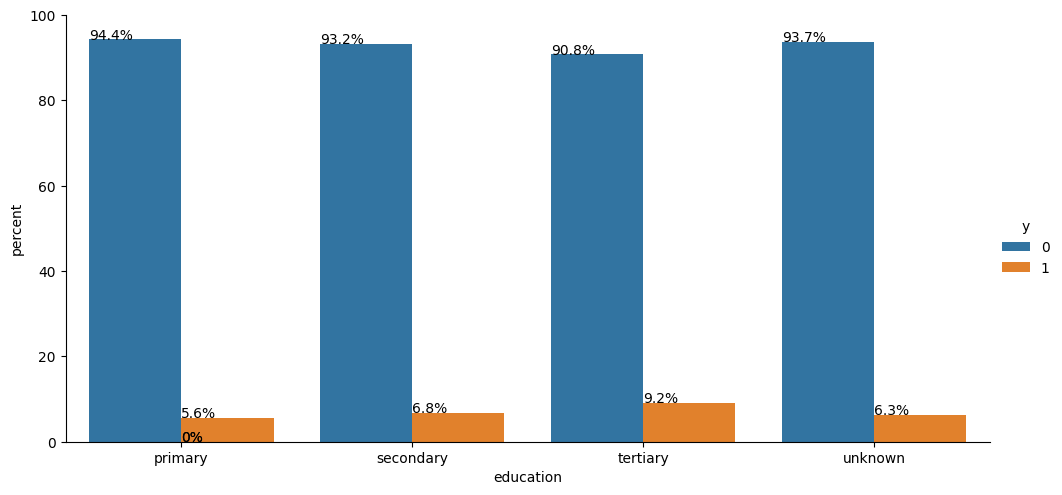

In [566]:
#Education by hue
df3 = tdm.groupby('education')['y'].value_counts(normalize=True)
df3 = df3.mul(100)
df3 = df3.rename('percent').reset_index()

g = sns.catplot(x='education',y='percent',hue='y',kind='bar',data=df3, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

<Axes: xlabel='default', ylabel='count'>

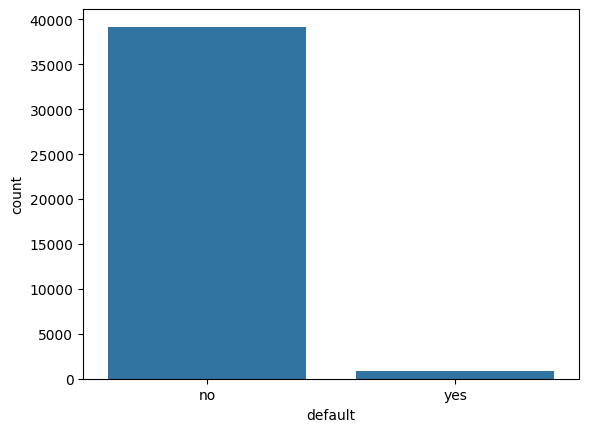

In [567]:
#Default
sns.countplot(data=tdm, x='default') 

### More than 80% of the respondents do not have credit in default but that didn't seem to be correlated to whether or not they subscribed to a term deposit.

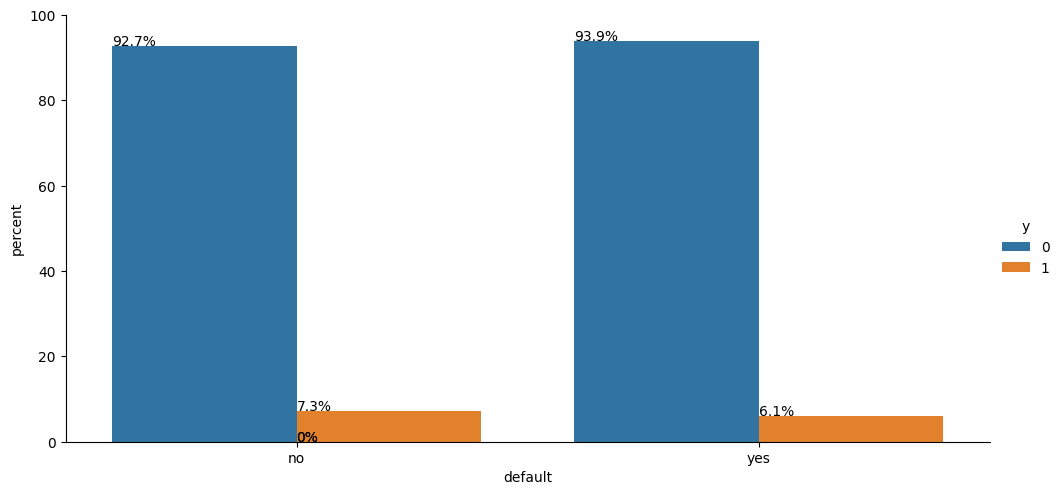

In [568]:
#Default by hue
df4 = tdm.groupby('default')['y'].value_counts(normalize=True)
df4 = df4.mul(100)
df4 = df4.rename('percent').reset_index()

g = sns.catplot(x='default',y='percent',hue='y',kind='bar',data=df4, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

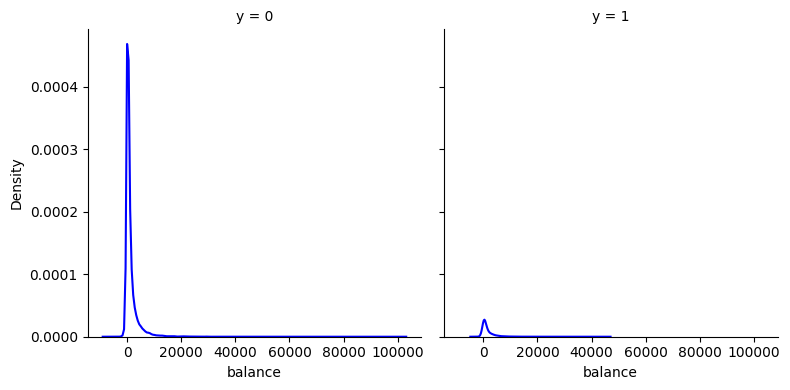

In [569]:
#Average yearly balance
g = sns.displot( kind='kde', data=tdm, x='balance',
                 col='y', col_wrap=2,
                 height=4, aspect=1, color='blue')

plt.show()

### The average yearly balance is really low.

<Axes: xlabel='housing', ylabel='count'>

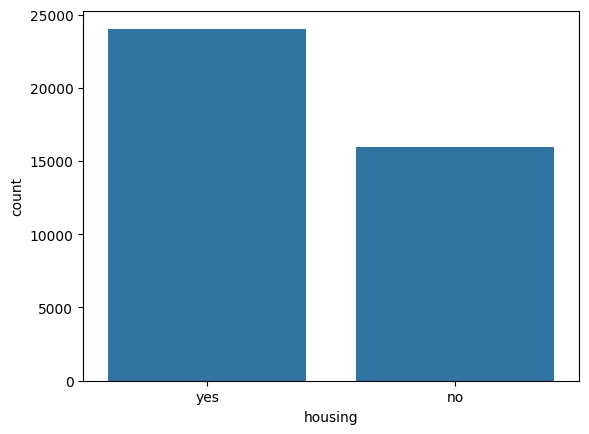

In [570]:
#Housing
sns.countplot(data=tdm, x='housing') 
#Housing loan does not seem to impact the responses.

### More than half of the population doesn't have a housing loan and among those, 9.0% subscribed compared to 6.1% of those who had an housing loan.

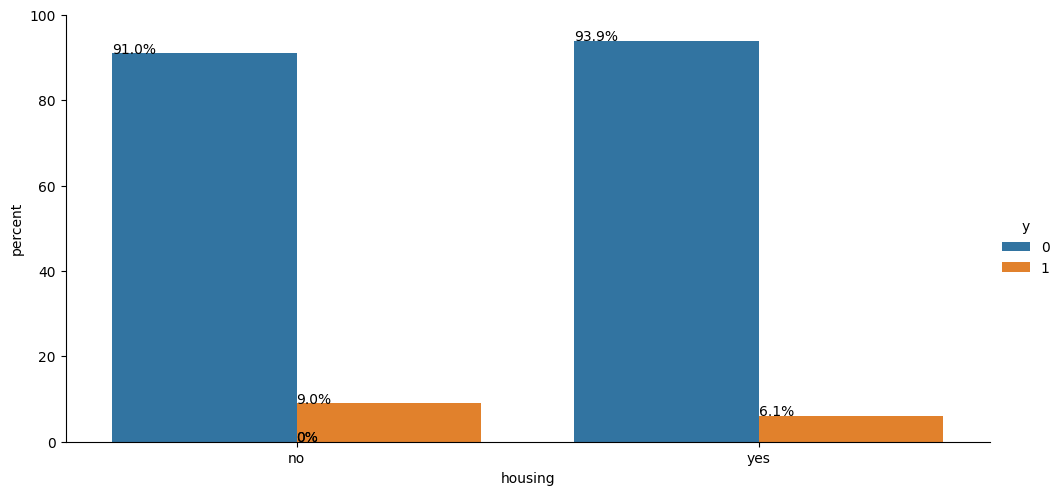

In [571]:
#Housing by hue
df5 = tdm.groupby('housing')['y'].value_counts(normalize=True)
df5 = df5.mul(100)
df5 = df5.rename('percent').reset_index()

g = sns.catplot(x='housing',y='percent',hue='y',kind='bar',data=df5, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

<Axes: xlabel='loan', ylabel='count'>

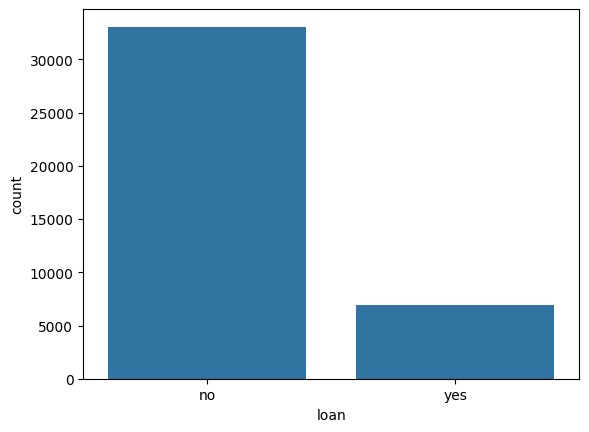

In [572]:
#Loan
sns.countplot(data=tdm, x='loan') 

### Personal loan does not seem to impact the responses.

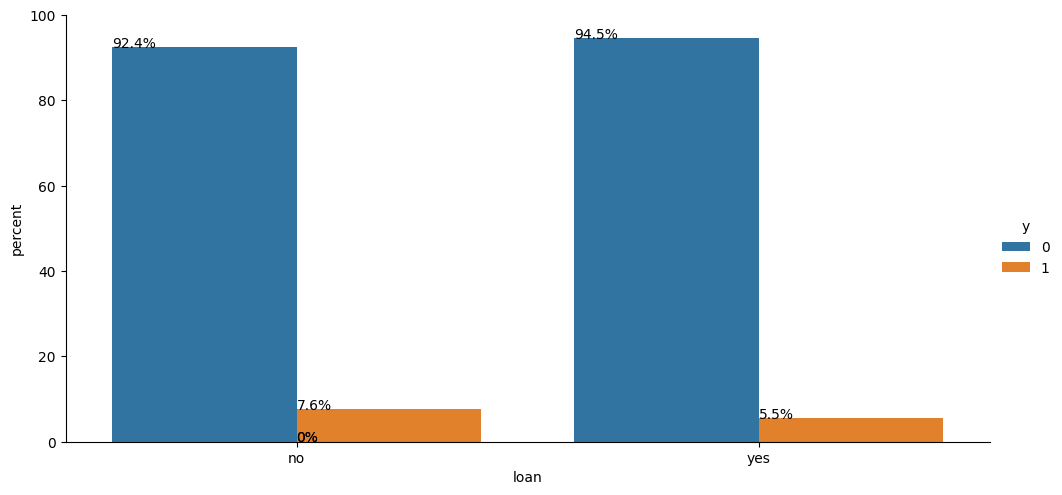

In [573]:
#Loan by hue
df7 = tdm.groupby('loan')['y'].value_counts(normalize=True)
df7 = df7.mul(100)
df7 = df7.rename('percent').reset_index()

g = sns.catplot(x='loan',y='percent',hue='y',kind='bar',data=df7, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

<Axes: xlabel='contact', ylabel='count'>

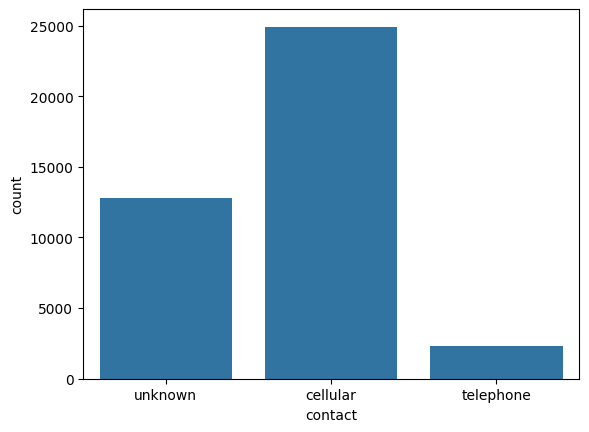

In [574]:
#Contact
sns.countplot(data=tdm, x='contact') 

### Method of contact does not seem to impact the responses.

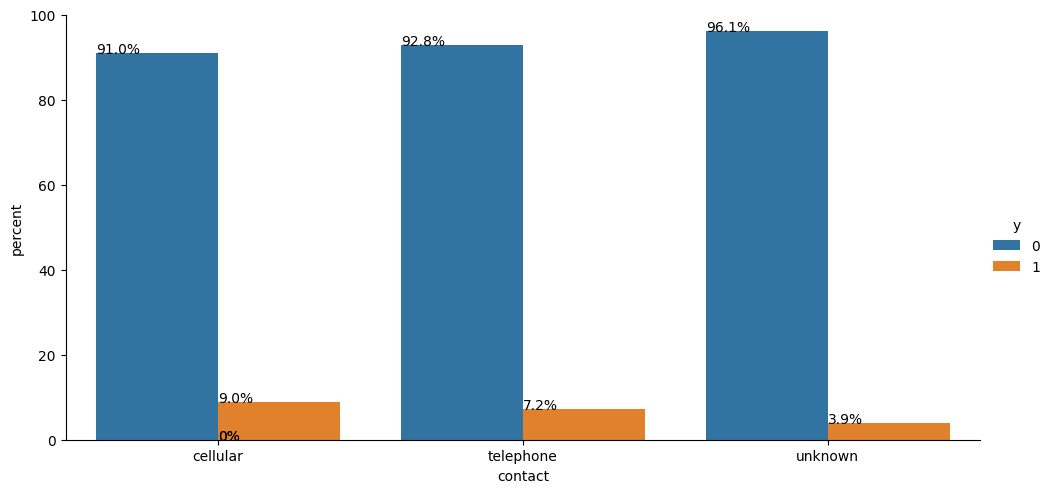

In [575]:
#Contact by hue
df6 = tdm.groupby('contact')['y'].value_counts(normalize=True)
df6 = df6.mul(100)
df6 = df6.rename('percent').reset_index()

g = sns.catplot(x='contact',y='percent',hue='y',kind='bar',data=df6, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

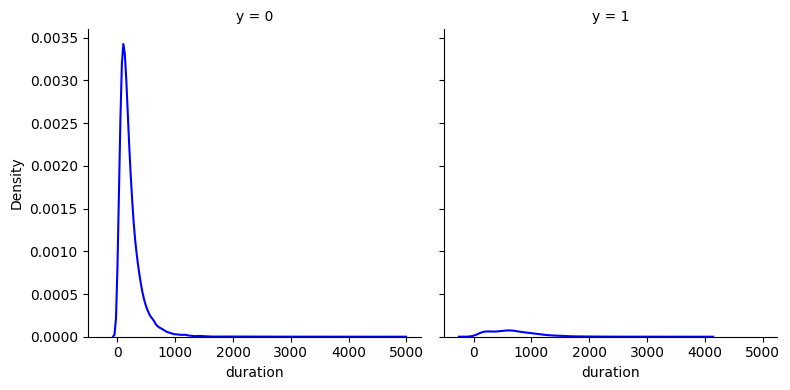

In [576]:
#Duration
g = sns.displot( kind='kde', data=tdm, x='duration',
                 col='y', col_wrap=2,
                 height=4, aspect=1, color='blue')

plt.show()

### Average duration is between 1 and 200.

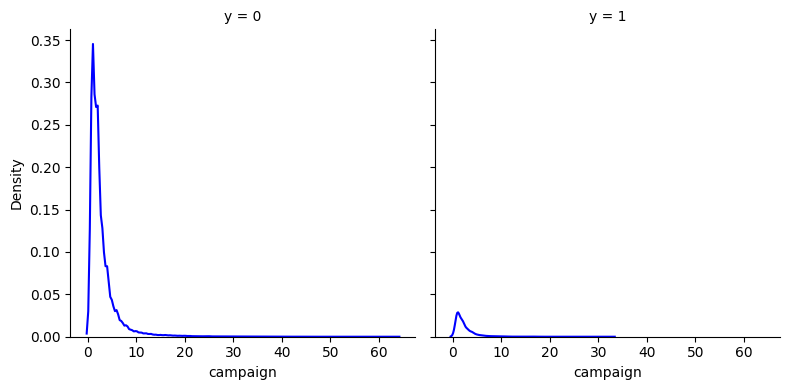

In [577]:
#Campaign
g = sns.displot( kind='kde', data=tdm, x='campaign',
                 col='y', col_wrap=2,
                 height=4, aspect=1, color='blue')

plt.show()

### 1 contact during the campaign has highest frequency.

## Data Modeling

### We will now use different classifiers and fit them on the train data to see which one generate the greated balanced accuracy score and use the best parameters from the one classifier to predict. But first, we will split the data and transform it since we have columns of mixed data types.

In [578]:
#Importing "train_test-split" function to test the model
from sklearn.model_selection import train_test_split


In [579]:
#Splitting the data
X=tdm.drop(['y'],axis=1)
y=tdm['y']

In [580]:
#Model Comparison using automatic nested cross-validation
# Compare classification algorithms
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=56)

In [581]:
#We have two different data types: object and int64. Using Column Transformer with mixed type.
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=75))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)

In [582]:
#First let us set up using Logistic Regression
#Build the pipeline
lg = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])

#Hyperparameters
lg_param ={'classifier__penalty':['none', 'l1', 'l2', 'elasticnet'], 
           'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear']}

# Perform random grid search  
lg_grid = RandomizedSearchCV(lg, lg_param, verbose=1, cv=5, n_jobs =-1, 
                             n_iter=10, scoring='balanced_accuracy',refit=True, random_state=56)
#Fitting the model on the train data
lg_result=lg_grid.fit(X_train, y_train)

print(f"Best Balanced Accuracy Score for Logistic Regression: {lg_result.best_score_:.4f}")
#return the grid features 
print(f"Best Parameters for Logistic Regression: {lg_grid.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best Balanced Accuracy Score for Logistic Regression: 0.6386
Best Parameters for Logistic Regression: {'classifier__solver': 'lbfgs', 'classifier__penalty': 'none'}


In [583]:
#Random Forest Classifier
#Build the pipeline
rf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())])

#Hyperparameters
rf_param ={'classifier__bootstrap': [True, False],
              'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'classifier__max_features': ['auto', 'sqrt', 'log2', None],
              'classifier__min_samples_leaf': [1, 2, 4, 25],
              'classifier__min_samples_split': [2, 5, 10, 25],
              'classifier__criterion': ['gini', 'entropy'],
              'classifier__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}


# Perform random grid search  
rf_grid = RandomizedSearchCV(rf, rf_param, verbose=1, cv=5, n_jobs =-1, 
                             n_iter=10, scoring='balanced_accuracy',refit=True, random_state=42)
#Fitting the model on the train data
rf_result=rf_grid.fit(X_train, y_train)

print(f"Best Balanced Accuracy Score for Random Forest Classifier: {rf_result.best_score_:.4f}")
#return the grid features 
print(f"Best Parameters for Random Forest Classifier: {rf_grid.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Balanced Accuracy Score for Random Forest Classifier: 0.6979
Best Parameters for Random Forest Classifier: {'classifier__n_estimators': 12, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': None, 'classifier__max_depth': 100, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}


In [584]:
#Naive Bayes
#Build the pipeline
from sklearn.naive_bayes import GaussianNB
nb = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", GaussianNB())])

#Hyperparameters
nb_param ={'classifier__var_smoothing': np.logspace(0,-9, num=100)}

# Perform random grid search  
nb_grid = RandomizedSearchCV(nb, nb_param, verbose=1, cv=5, n_jobs = -1, 
                             n_iter=10, scoring='balanced_accuracy',refit=True, random_state=42)
#Fitting the model on the train data
nb_result=nb_grid.fit(X_train, y_train)

print(f"Best Balanced Accuracy Score for Naive Bayes Classifier: {nb_result.best_score_:.4f}")
#return the grid features 
print(f"Best Parameters for Naive Bayes Classifier: {nb_grid.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Balanced Accuracy Score for Naive Bayes Classifier: 0.7095
Best Parameters for Naive Bayes Classifier: {'classifier__var_smoothing': 0.01}


In [585]:
#KNN
#Build the pipeline
from sklearn.neighbors import KNeighborsClassifier
kn = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())])

#Hyperparameters
kn_param ={
    'classifier__n_neighbors': (1,10, 1),
    'classifier__leaf_size': (20,40,1),
    'classifier__p': (1,2),
    'classifier__weights': ('uniform', 'distance'),
    'classifier__metric': ('minkowski', 'chebyshev')}
                   
# Perform random grid search  
kn_grid = RandomizedSearchCV(kn, kn_param, verbose=1, cv=5, n_jobs = -1, 
                             n_iter=10, scoring='balanced_accuracy',refit=True, random_state=42)
#Fitting the model on the train data
kn_result=kn_grid.fit(X_train, y_train)

print(f"Best Balanced Accuracy Score for K Nearest Neighbhor Classifier: {kn_result.best_score_:.4f}")
#return the grid features 
print(f"Best Parameters for K Nearest Neighbhor Classifier: {kn_grid.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Balanced Accuracy Score for K Nearest Neighbhor Classifier: 0.6782
Best Parameters for K Nearest Neighbhor Classifier: {'classifier__weights': 'uniform', 'classifier__p': 2, 'classifier__n_neighbors': 1, 'classifier__metric': 'minkowski', 'classifier__leaf_size': 1}


In [586]:
#Decision Tree
dt = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())])

#Hyperparameters
dt_param ={'classifier__max_depth': [1, 10, 20, 30, 50],
              'classifier__max_features': [1, 2, 3, 4, 5]}
           
# Perform random grid search  
dt_grid = RandomizedSearchCV(dt, dt_param, verbose=1, cv=5, n_jobs =-1, 
                             n_iter=10, scoring='balanced_accuracy',refit=True, random_state=42)
#Fitting the model on the train data
dt_result=dt_grid.fit(X_train, y_train)

print(f"Best Balanced Accuracy Score for Decision Tree Classifier: {dt_result.best_score_:.4f}")
#return the grid features 
print(f"Best Parameters for Decision Tree Classifier: {dt_grid.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Balanced Accuracy Score for Decision Tree Classifier: 0.6673
Best Parameters for Decision Tree Classifier: {'classifier__max_features': 4, 'classifier__max_depth': 50}


In [587]:
#XGBoost
import xgboost
xg = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgboost.XGBClassifier())])

#Hyperparameters
xg_param ={'classifier__min_child_weight': [1, 5, 10],
        'classifier__gamma': [0,0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.3, 0.6, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 5]}
           
# Perform random grid search  
xg_grid = RandomizedSearchCV(xg, xg_param, verbose=1, cv=5, n_jobs =-1, 
                             n_iter=10, scoring='balanced_accuracy',refit=True, random_state=42)
#Fitting the model on the train data
xg_result=xg_grid.fit(X_train, y_train)

print(f"Best Balanced Accuracy Score for XGBoost Classifier: {xg_result.best_score_:.4f}")
#return the grid features 
print(f"Best Parameters for XGBoost Classifier: {xg_grid.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Balanced Accuracy Score for XGBoost Classifier: 0.7037
Best Parameters for XGBoost Classifier: {'classifier__subsample': 0.8, 'classifier__min_child_weight': 1, 'classifier__max_depth': 5, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}


### The model with the highest accuracy score is Naive Bayes with 0.7095.
### Let's find the optimal threshold for that model.

In [588]:
nb_grid.best_params_
nb_best_params= { k.replace('classifier__', ''): v for k, v in nb_grid.best_params_.items() }
nb_best_params

{'var_smoothing': 0.01}

In [589]:
nb_pred = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", GaussianNB(**nb_best_params))])
nb_pred.fit(X_train, y_train)
# predict probabilities, keep probabilities for the positive outcome only
yhat = nb_pred.predict_proba(X_train)[:,1]
# Figure out which threshold gets the best accuracy score
threshold = []
accuracy = []

for p in np.unique(yhat):
  threshold.append(p)
  y_pred = (yhat >= p).astype(int)
  accuracy.append(balanced_accuracy_score(y_train,y_pred))

threshold_optimal=threshold[np.argmax(accuracy)]
print(f"Optimal Threshold for Naive Bayes on Training Data: {threshold_optimal:.4f}")

Optimal Threshold for Naive Bayes on Training Data: 0.0329


In [590]:
#Make final prediction
test_acc = balanced_accuracy_score(y_test, nb_pred.predict_proba(X_test)[:,1] > threshold_optimal)
print(f"Accuracy Score for Test Data using Naive Bayes Classifier: {test_acc:.4f}")

Accuracy Score for Test Data using Naive Bayes Classifier: 0.7844


### The accuracy score of the test data is 0.7844 which is close enough to 81%.

In [591]:
#Let's test to see if 78.44% is statistically signicant compared to 81%. We will perform a binomial test.
# H0: p=0.81 & H1: p<0.81
from scipy.stats import binom_test
count = test_acc*len(X_test)
nobs = len(X_test)
binom_test(x=count, n=nobs, p=0.81, alternative='less')

2.3674460531477784e-05

### Since the p-value is almost 0, we reject the null hypothesis and conclude that there is enough evidence to say that the balanced accuracy score of 0.7844 is statistically different than 0.81. 

## Which customers are most likely to buy the investment product?

### We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

In [592]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#One hot encoding categorical variables
columns_encode=['job', 'marital','education','default','housing','loan','contact','month']
encoder = OneHotEncoder()
X_clus=X.copy()

for col in columns_encode:
  onehot = encoder.fit_transform(X_clus[[col]])
  feature_names = encoder.categories_[0]
  onehot_df = pd.DataFrame(onehot.toarray(), columns=feature_names)
  X_clus= pd.concat([X_clus, onehot_df], axis=1)

X_clus.drop(columns_encode, axis=1, inplace=True)

num_cols = ['balance','day', 'duration', 'campaign']
scaler = StandardScaler()

#for loop
for col in num_cols:
    X_clus[col] = scaler.fit_transform(X_clus[[col]])

X_clus.head()

,age,balance,day,duration,campaign,admin,blue-collar,entrepreneur,housemaid,management,...,aug,dec,feb,jan,jul,jun,mar,may,nov,oct
0,58,0.299174,-1.3309,0.023811,-0.581096,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,44,-0.428854,-1.3309,-0.400305,-0.581096,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,33,-0.438152,-1.3309,-0.689474,-0.581096,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,47,0.079802,-1.3309,-0.627785,-0.581096,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,33,-0.438497,-1.3309,-0.219092,-0.581096,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


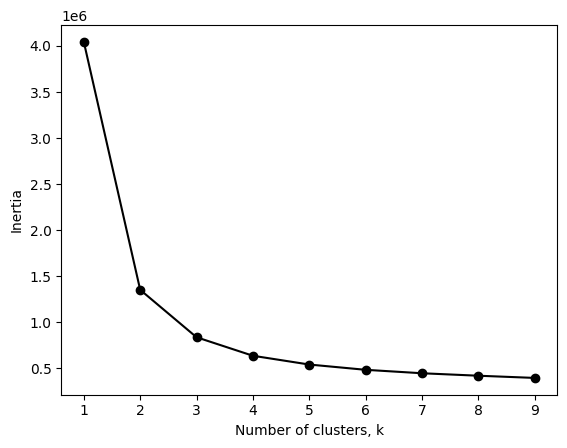

In [593]:
ks = range(1,10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=50, random_state=46)
    kmeans.fit(X_clus,y)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

### It looks like the optimal number of clusters is 3. To compare attributes of the different clusters, let's find the average of all variables across each cluster.

In [594]:
kmeans3 = KMeans(n_clusters=3, init='k-means++', n_init=50, max_iter=50, random_state=46)
kmeans3.fit(X_clus,y)

# map back clusters to dataframe

pred = kmeans3.predict(X_clus,y)
frame = pd.DataFrame(X_clus)
frame['cluster'] = pred
frame.head()

,age,balance,day,duration,campaign,admin,blue-collar,entrepreneur,housemaid,management,...,dec,feb,jan,jul,jun,mar,may,nov,oct,cluster
0,58,0.299174,-1.3309,0.023811,-0.581096,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,44,-0.428854,-1.3309,-0.400305,-0.581096,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
2,33,-0.438152,-1.3309,-0.689474,-0.581096,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,47,0.079802,-1.3309,-0.627785,-0.581096,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,33,-0.438497,-1.3309,-0.219092,-0.581096,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


### We can now see that each row is assigned to a cluster. We will group the data by cluster.

In [595]:
avg_X_clus = frame.groupby(['cluster'], as_index=False).mean()
avg_X_clus.head()

,cluster,age,balance,day,duration,campaign,admin,blue-collar,entrepreneur,housemaid,...,aug,dec,feb,jan,jul,jun,mar,may,nov,oct
0,0,31.388858,-0.070196,0.025925,0.039290,-0.019107,0.123274,0.230736,0.027124,0.013927,...,0.111598,0.000365,0.062823,0.034483,0.154108,0.076324,0.007906,0.389892,0.079791,0.001946
1,1,53.825239,0.119174,-0.003023,-0.043342,0.016234,0.092647,0.207334,0.039984,0.046811,...,0.171055,0.000293,0.055588,0.028087,0.174664,0.152233,0.007509,0.256485,0.099571,0.001853
2,2,41.624671,-0.005095,-0.029714,-0.015155,0.011103,0.113208,0.260317,0.041269,0.028415,...,0.122228,0.000301,0.052094,0.024130,0.154476,0.144178,0.003834,0.337593,0.095091,0.002180


### Let's find out if the clusters come from the same distributions.

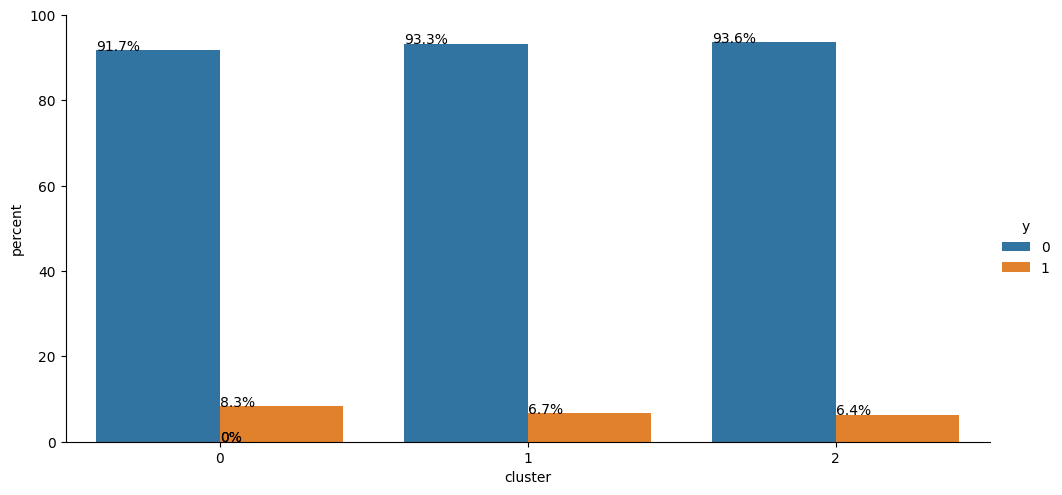

In [596]:
#See responses by cluster
tdm_clus=tdm.join(frame['cluster']) #joining the cluster column to original data

df8 = tdm_clus.groupby('cluster')['y'].value_counts(normalize=True)
df8 = df8.mul(100)
df8 = df8.rename('percent').reset_index()

g = sns.catplot(x='cluster',y='percent',hue='y',kind='bar',data=df8, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### As we can see from the plot, there is not a big difference is the proportion of respondents who subscribed based on the classification by cluster although 8.3% subscribed in cluster 0, 6.7% in cluster 1 and 6.4% in cluster 2. Let's look at different variables by cluster. Let's see if 8.3% is statistically significant compared to 6.7% and 6.4%.

In [597]:
y_clus=tdm_clus.groupby(['cluster','y'], sort=False).size().reset_index(name='Count')
y_clus

,cluster,y,Count
0,1,0,9569
1,2,0,12457
2,0,0,15078
3,1,1,685
4,2,1,846
5,0,1,1365


In [598]:
C0=len(tdm_clus[tdm_clus['cluster']==0])
C1=len(tdm_clus[tdm_clus['cluster']==1])
C2=len(tdm_clus[tdm_clus['cluster']==2])
C0_yes=len(tdm_clus[(tdm_clus['cluster']==0) & (tdm_clus['y']==1)])
C1_yes=len(tdm_clus[(tdm_clus['cluster']==1) & (tdm_clus['y']==1)])
C2_yes=len(tdm_clus[(tdm_clus['cluster']==2) & (tdm_clus['y']==1)])

In [599]:
#Testing cluster 0 with cluster 1 using z-test for proportions
# H0: p1=p2  H1 p1/=p2
from statsmodels.stats.proportion import proportions_ztest
count01 = np.array([C0_yes,C1_yes],dtype=float)
nobs01 = np.array([C0,C1], dtype=float)
stat, pval = proportions_ztest(count01, nobs01)
print('{0:0.3f}'.format(pval))

0.000


In [600]:
#Testing cluster 0 with cluster 2
# H0: p1=p2  H1 p1/=p2
count02 = np.array([C0_yes,C2_yes],dtype=float)
nobs02 = np.array([C0,C2], dtype=float)
stat, pval = proportions_ztest(count02, nobs02)
print('{0:0.3f}'.format(pval))

0.000


### Since in both cases (cluster 0 vs 1 or 2), the P-value is 0, we reject the null hypothesis and conclude that the propertion of respondents who subscribed in cluster 0 is statiscally significant compared to the proportions in clusters 1 and 2.

<Axes: xlabel='cluster', ylabel='age'>

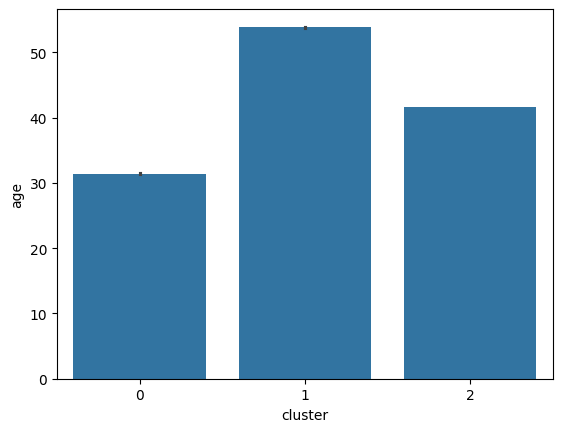

In [601]:
sns.barplot(x='cluster',y='age',data=tdm_clus)

<Axes: xlabel='cluster', ylabel='balance'>

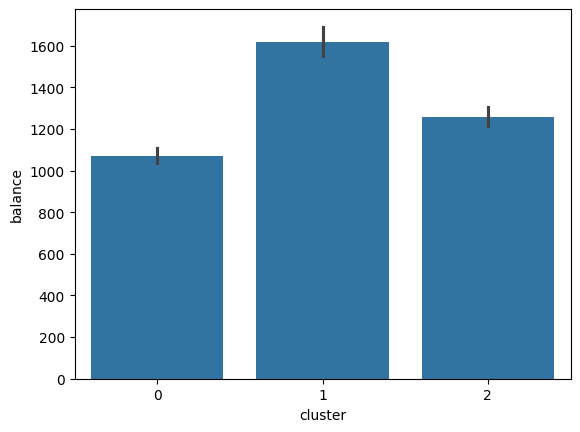

In [602]:
sns.barplot(x='cluster',y='balance',data=tdm_clus)

<Axes: xlabel='cluster', ylabel='duration'>

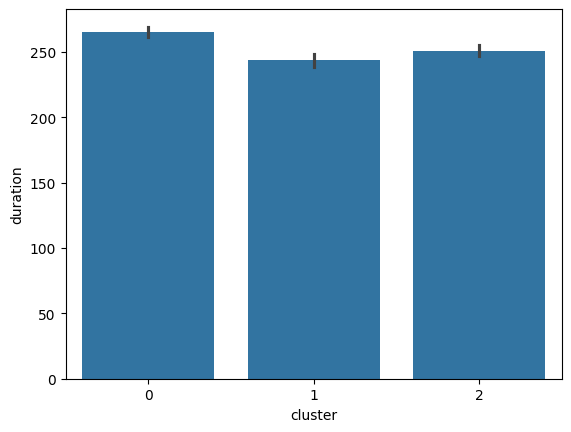

In [603]:
sns.barplot(x='cluster',y='duration',data=tdm_clus)

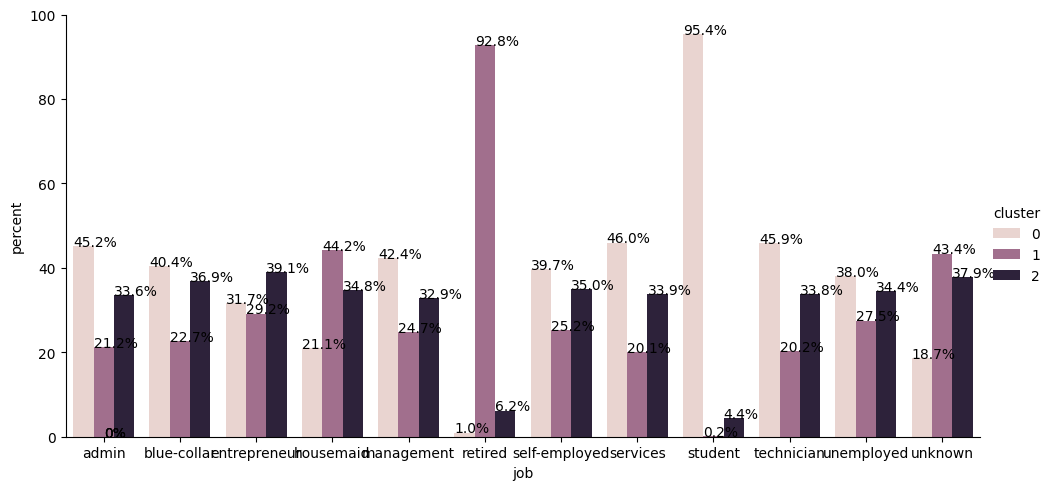

In [604]:
#Job by cluster
#plt.figure(figsize=(15,8))
#sns.countplot(tdm_clus, x="job", hue="cluster")
df9 = tdm_clus.groupby('job')['cluster'].value_counts(normalize=True)
df9 = df9.mul(100)
df9 = df9.rename('percent').reset_index()

g = sns.catplot(x='job',y='percent',hue='cluster',kind='bar',data=df9, height=5, aspect=2)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### From the different plots we can see that the respondents in cluster 0 are in their thirties and the duration of their contact is greater than that of the other clusters and they have a lower yearly balance.
### Cluster 0 is also mostly comprised of students compared to the other clusters therefore what segment of customers should the client prioritize? Mid-thirties students with almost no yearly balance and had a long last contact duration.

## What makes the customers buy? Tell us which feature we should be focusing more on.

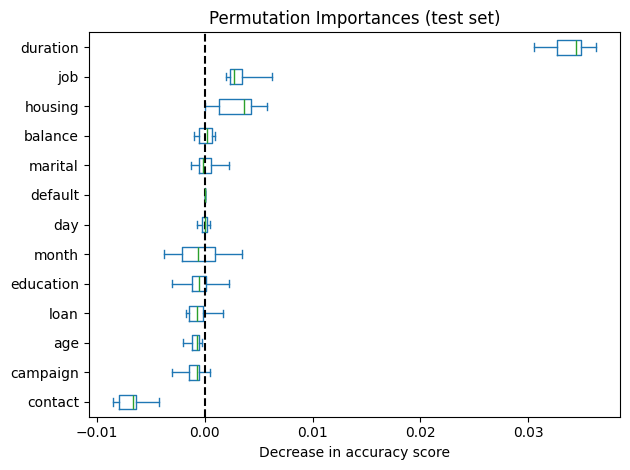

In [605]:
#Permutation_importance
from sklearn.inspection import permutation_importance

result = permutation_importance(
    nb_pred, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Permutation importantace shows that 4 variables (duration, job, housing, balance) are the most important features. Permuting the values of these features will lead to most decrease in accuracy score of the model on the test set.

PermutationExplainer explainer: 40001it [15:18, 43.04it/s]                           


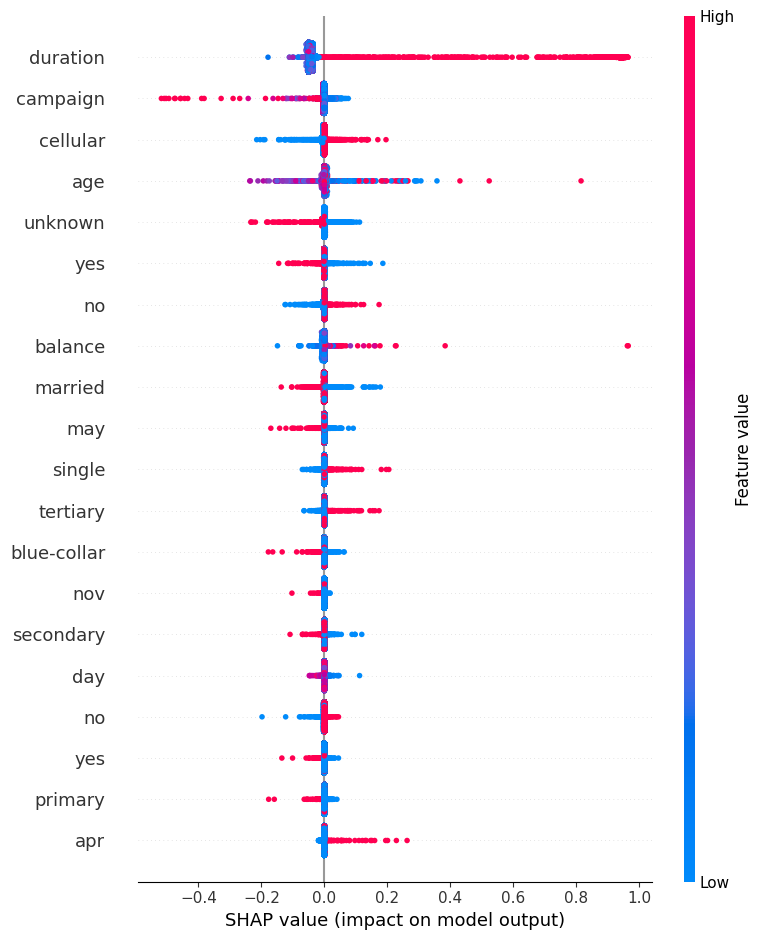

In [607]:
#SHAP shows the contribution or the importance of each feature on the prediction of the model
#Features with positive SHAP values positively impact the prediction, while those with negative values 
#have a negative impact. The magnitude is a measure of how strong the effect is.
import shap
shap.initjs()

gnb=GaussianNB(var_smoothing=0.01)
gnb.fit(X_clus,y)
#Setting up shap explainer
explainer = shap.Explainer(gnb.predict, X_clus)
shap_values = explainer.shap_values(X_clus)
shap.summary_plot(shap_values, X_clus)

### From the SHAP value plot, we can see that the duration variable positively impacts the prediction the most, followed by balance. On the other hand, the campaign variable negatively impacts the prediction the most.